In [10]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv('process_csv_stage_3.csv')
df

,old_index,preprocessed_text,topic_lda,priority
0,1,good morning name appreciate could help put st...,0,3
1,2,upgraded card tell agent upgrade anniversary d...,3,1
2,10,chase card report however fraudulent applicati...,6,2
3,11,try book ticket come across offer apply toward...,3,3
4,14,grand son give check deposit chase account fun...,4,3
...,...,...,...,...
21067,78303,chase card customer well decade offer multiple...,3,3
21068,78309,wednesday call chas visa credit card provider ...,8,1
21069,78310,familiar pay understand great risk provide con...,2,2
21070,78311,flawless credit chase credit card chase freedo...,7,3


# Data Partition

In [12]:
# deal with class imbalance: oversampling for ticket priority
class_counts = df['priority'].value_counts()
class_weights = len(class_counts)/class_counts
df = df.sample(
    n=class_counts.max()*len(class_counts),
    weights=df['priority'].map(class_weights), 
    replace=True,
    random_state=42)
df.value_counts('priority')

priority
2    10634
3    10488
1    10486
Name: count, dtype: int64

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df['preprocessed_text']

vectorizer = TfidfVectorizer(
    max_df=0.8,
    min_df=0.05,
    max_features=10000
)
X = vectorizer.fit_transform(corpus)
X.shape

(31608, 301)

In [14]:
vectorizer.get_feature_names_out()

array(['able', 'accept', 'access', 'account', 'act', 'action', 'activity',
       'add', 'additional', 'address', 'advise', 'agency', 'ago', 'agree',
       'allow', 'already', 'also', 'amount', 'another', 'answer',
       'anything', 'appear', 'application', 'apply', 'approve', 'around',
       'ask', 'attach', 'attempt', 'attorney', 'authorize', 'available',
       'away', 'back', 'balance', 'bank', 'banking', 'base', 'begin',
       'believe', 'bill', 'branch', 'bureau', 'business', 'call',
       'cancel', 'card', 'case', 'cash', 'cause', 'cfp', 'change',
       'charge', 'check', 'claim', 'clear', 'clearly', 'close', 'come',
       'company', 'complaint', 'complete', 'concern', 'confirm',
       'consumer', 'contact', 'continue', 'copy', 'correct', 'could',
       'credit', 'current', 'customer', 'date', 'day', 'debit', 'debt',
       'decide', 'deny', 'department', 'deposit', 'different', 'dispute',
       'document', 'documentation', 'dollar', 'due', 'either', 'email',
       'e

In [15]:
# save vectorizer
import os
from pickle import dump
with open(os.path.join(os.getcwd(),'ml_models',"vectorizer_005_080_10000.pkl"), "wb") as f:
    dump(vectorizer, f, protocol=5)

In [16]:
y = df[['topic_lda','priority']]

In [17]:
# split into training set (test set?) and validation set

# train = 80, test = 20
# random_seed = 42
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# y1 = df['topic_lda']
# y2 = df['priority']

# X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state=42)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# print(y1_train.shape)
# print(y1_test.shape)
# print(y2_train.shape)
# print(y2_test.shape)

(25286, 301)
(6322, 301)
(25286, 2)
(6322, 2)


# Model Building

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [20]:
dt_preds = dt.predict(X_test)
dt_preds

array([[0, 1],
       [1, 2],
       [2, 3],
       ...,
       [6, 3],
       [0, 1],
       [0, 2]], dtype=int64)

In [21]:
Y_test = y_test.to_numpy()

In [22]:
# np.all(dt_preds==Y_test,axis=1).sum()/(np.shape(Y_test)[0])
np.mean(np.all(Y_test == dt_preds, axis=1))

0.804808604871876

In [23]:
dt_preds[:, 0]

array([0, 1, 2, ..., 6, 0, 0], dtype=int64)

In [24]:
dt_preds[:, 1]

array([1, 2, 3, ..., 3, 1, 2], dtype=int64)

# Evaluation

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

================ Ticket Category =================
Accuracy:  0.8687124327744384
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      1333
           1       0.89      0.90      0.89       712
           2       0.84      0.84      0.84       319
           3       0.81      0.79      0.80       452
           4       0.89      0.90      0.90      1015
           5       0.87      0.86      0.87       511
           6       0.87      0.87      0.87       646
           7       0.87      0.86      0.87       702
           8       0.85      0.86      0.85       632

    accuracy                           0.87      6322
   macro avg       0.86      0.86      0.86      6322
weighted avg       0.87      0.87      0.87      6322



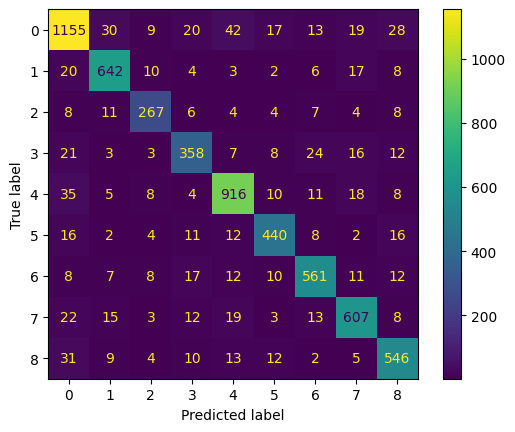

In [26]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=dt_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], dt_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=dt_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.8639670990192977
Classification Report:
               precision    recall  f1-score   support

           1       0.88      0.91      0.89      2098
           2       0.84      0.86      0.85      2126
           3       0.88      0.82      0.85      2098

    accuracy                           0.86      6322
   macro avg       0.86      0.86      0.86      6322
weighted avg       0.86      0.86      0.86      6322



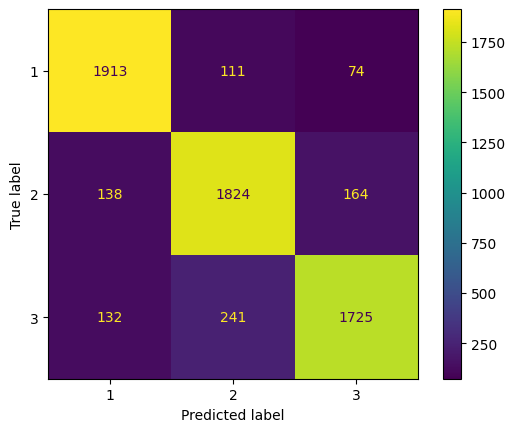

In [27]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=dt_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], dt_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=dt_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Tuning

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
param_grid = {
    "min_samples_split": np.linspace(0.0001, 0.0005, 5),
    "min_samples_leaf": np.linspace(0.00005, 0.0001, 5),
    "max_depth":[10,20,50],
    "max_leaf_nodes":[5,10,50,100]
}

In [30]:
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2)

In [31]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 50],
                         'max_leaf_nodes': [5, 10, 50, 100],
                         'min_samples_leaf': array([5.00e-05, 6.25e-05, 7.50e-05, 8.75e-05, 1.00e-04]),
                         'min_samples_split': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005])},
             verbose=2)

In [32]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'max_depth': 10, 'max_leaf_nodes': 5, 'min_samples_leaf': 5e-05, 'min_samples_split': 0.0001}


In [33]:
bestdt = grid_search.best_estimator_

[Text(0.7142857142857143, 0.9, 'x[70] <= 0.164\ngini = 0.768\nsamples = 25286\nvalue = [[5330, 2848, 1274, 1806, 4063, 2044, 2586, 2807, 2528]\n[8388, 8508, 8390, 0, 0, 0, 0, 0, 0]]'),
 Text(0.5714285714285714, 0.7, 'x[107] <= 0.006\ngini = 0.758\nsamples = 20853\nvalue = [[4848, 2667, 1158, 850, 3936, 1812, 1001, 2386, 2195]\n[7761, 7496, 5596, 0, 0, 0, 0, 0, 0]]'),
 Text(0.42857142857142855, 0.5, 'x[163] <= 0.019\ngini = 0.758\nsamples = 16779\nvalue = [[3722, 2512, 851, 791, 3122, 831, 864, 2283, 1803]\n[5037, 6597, 5145, 0, 0, 0, 0, 0, 0]]'),
 Text(0.2857142857142857, 0.3, 'x[82] <= 0.047\ngini = 0.753\nsamples = 14070\nvalue = [[3327, 953, 664, 773, 3040, 826, 811, 1914, 1762]\n[4162, 5648, 4260, 0, 0, 0, 0, 0, 0]]'),
 Text(0.14285714285714285, 0.1, 'gini = 0.744\nsamples = 11767\nvalue = [[2880, 923, 559, 740, 2906, 619, 634, 1810, 696]\n[3016, 4885, 3866, 0, 0, 0, 0, 0, 0]]'),
 Text(0.42857142857142855, 0.1, 'gini = 0.67\nsamples = 2303\nvalue = [[447, 30, 105, 33, 134, 207, 177

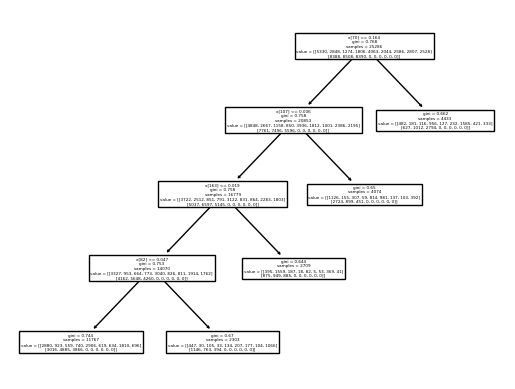

In [34]:
from sklearn.tree import plot_tree
plot_tree(bestdt)

In [35]:
bestdt_preds = bestdt.predict(X_test)
best_dt_score = np.mean(np.all(Y_test == bestdt_preds, axis=1))
print("Best model accuracy:", best_dt_score)

Best model accuracy: 0.15881050300537805


# Evaluation After Tuning

================ Ticket Category =================
Accuracy:  0.31683011705156594
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.20      0.23      1333
           1       0.56      0.53      0.54       712
           2       0.00      0.00      0.00       319
           3       0.00      0.00      0.00       452
           4       0.24      0.68      0.36      1015
           5       0.00      0.00      0.00       511
           6       0.34      0.62      0.44       646
           7       0.00      0.00      0.00       702
           8       0.45      0.42      0.43       632

    accuracy                           0.32      6322
   macro avg       0.21      0.27      0.22      6322
weighted avg       0.24      0.32      0.26      6322



C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


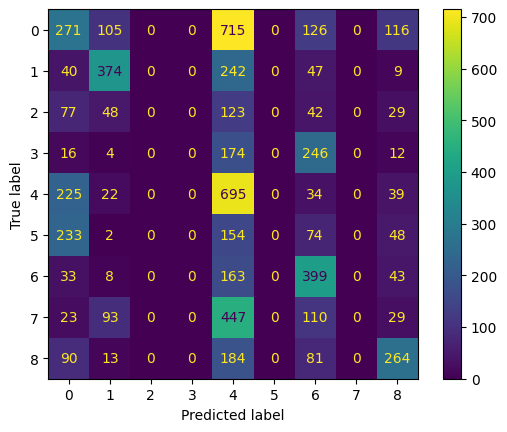

In [36]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=bestdt_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], bestdt_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=bestdt_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.4892439101550142
Classification Report:
               precision    recall  f1-score   support

           1       0.61      0.46      0.52      2098
           2       0.40      0.66      0.50      2126
           3       0.62      0.34      0.44      2098

    accuracy                           0.49      6322
   macro avg       0.54      0.49      0.49      6322
weighted avg       0.54      0.49      0.49      6322



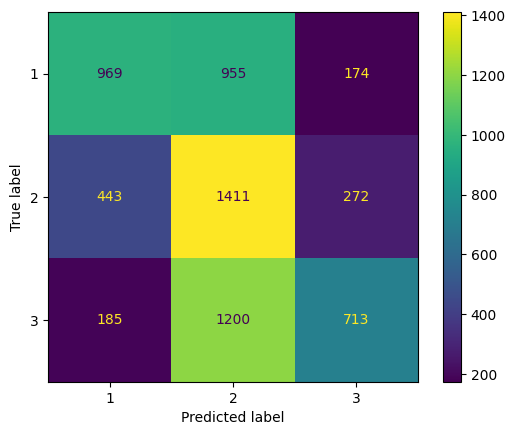

In [37]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=bestdt_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], bestdt_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=bestdt_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Save tuned model to disk

In [38]:
import os
from pickle import dump
with open(os.path.join(os.getcwd(),'ml_models',"tuned_dt_single.pkl"), "wb") as f:
    dump(bestdt, f, protocol=5)